In [38]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import json
import os
import datetime
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import pandas as pd
from sklearn import metrics
# import tqdm
from tqdm import tqdm
import lightning as L

In [39]:
# torch.version.cuda
# print(torch.version.cuda)
L.seed_everything(42)

Global seed set to 42


42

### Feature extraction

In [2]:
file = open("config.json")
config = json.load(file)
# print(config.keys())
print(config['data']['frame_size'])

512


In [3]:
fs = 44100              # Hz, sampling frequency
f_size = config['data']['frame_size']
h_size = config['data']['hop_size']
n_mel_channels = config['data']['n_mel_channels']

supra_frame_duration = 0.5  # seconds
supra_frame_length = round(supra_frame_duration / (h_size/fs)) # need to read from config.json / 

dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep
directory_ALS = os.listdir(dir_ALS)
directory_HC = os.listdir(dir_HC)

### Pre-analysis (transform wav-file to mel-spectrogramms)

In [5]:
X = np.zeros((20000,n_mel_channels, supra_frame_length))   # data
y = np.zeros((20000,1))                     # labels
X_global_index = 0
X_ids = list([])
# Cycle for HC (helthy controls)
for i in range(len(directory_HC)):    
    if directory_HC[i][-5:]=='a.wav':
        # print(directory_HC[i][-5:])
        fileName = dir_HC + directory_HC[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]    

        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_HC + directory_HC[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_HC[i][0:3]))
#             y[X_global_index] = 0
#             X_global_index = X_global_index +1
    
# Cycle for ALS (pathology)
for i in range(len(directory_ALS)):
    if directory_ALS[i][-5:]=='a.wav':
        fileName = dir_ALS + directory_ALS[i]
        x, sr = librosa.load(fileName, sr=None, mono=True, offset=0.0, duration=None)

        X_melspec = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=64, n_fft=f_size, hop_length=h_size, window='hann', center=False, power=1.0)
        X_melspec = 20*np.log10(X_melspec)
            
        frame_num = X_melspec.shape[1]
     
        X_melspec = X_melspec.astype(np.half)
        X_melspec.tofile(dir_ALS + directory_ALS[i][:-4] +'_mel.dat')

# #       #Запись фрагметов спектра в трехмерный массив 
#         N_supra_frames = frame_num - supra_frame_length + 1

#         # generator comprehension
#         gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
#         for n in gen_range:
#             X[X_global_index,:,:] = X_melspec[:,n:n+supra_frame_length]
#             X_ids.append(int(directory_ALS[i][0:3]))
#             y[X_global_index] = 1
#             X_global_index = X_global_index + 1


### Dataset and Dataloader

In [4]:
class ALSDataset(Dataset):
    def __init__(self, dir_HC_path, dir_ALS_path):
        """
        Аргументы:
            dir_HC_path -- путь к папке с записями здоровых голосов
            dir_ALS_path -- путь к папке с записями голосов пациентов с БАС
        """
        # self.dir_HC_path = []
        # self.dir_ALS_path = []
        self._ids = list([])    # speaker IDs
        # 5-fold CV: 13+13+13+13+12
        # ALS: 8,20,21, 22, 24, 25,27,28,31,32,39, 42,46,48,52,55,58,62,64,68,72,76,78,80,84,92,94,96,98,100,102
        # HC : 131, 129, 127, 125, 123, 121, 119, 117, 115, 113, 111, 109, 107, 99, 97, 89, 86, 85, 81, 77, 65, 63, 61, 53, 49, 42, 28, 26, 24, 16, 6, 4, 2 
        
                                                                                        # HC men+women / ALS men+women
        self.folds = list(([26,   97, 117,  85,  53,  86, 127,  92, 102,  27,  32,  72,  39], # 3+4 HC / 3+3 ALS
                           [28,  123,  63,  99,  81, 125, 129,  68,  21,  55,  48,  78,  42], # 3+4 HC / 4+2 ALS
                           [61,   16, 115, 109, 111,   2, 107,  46,  84,  64,  52,  24,  76], # 2+5 HC / 4+2 ALS
                           [77,    6,  65,  24, 131, 119,  25,  94,  62,  28,   8,  98,  22], # 3+3 HC / 5+2 ALS
                           [49,   89,   4,  42, 113, 121,  96,  20,  58,  80,  31, 100]))     # 2+4 HC / 4+2 ALS
        
        self.folds_val = list(([49, 42, 20, 31],
                              [97, 53,  92, 32],
                              [28, 99, 129, 55],  
                              [61, 111, 84, 76],  
                              [77, 24, 94, 8]))
                              
        f_size = 512            # need to read from config.json
        h_size = 256            # need to read from config.json
        n_mel_channels = 64     # need to read from config.json
        supra_frame_length = 86 # need to read from config.json
        self.X = np.zeros((20000, n_mel_channels, supra_frame_length))   # data
        self.y = np.zeros((20000,1))                         # labels
        X_global_index = 0
        self.X_ids = list([])

        # Cycle for HC (helthy controls)        
        directory_HC = os.listdir(dir_HC_path)       
        for i in range(len(directory_HC)):
            if directory_HC[i][-9:]=='a_mel.dat':
                fileName = dir_HC + directory_HC[i]
            
                X_spec = np.fromfile(dir_HC + directory_HC[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))        

                #Запись фрагметов спектра в трехмерный массив 
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:] = X_spec[:,n:n+supra_frame_length]
                    self.X_ids.append(int(directory_HC[i][0:3]))
                    self.y[X_global_index] = 0
                    X_global_index = X_global_index +1

        # Cycle for ALS (pathology)
        directory_ALS = os.listdir(dir_ALS_path)       
        for i in range(len(directory_ALS)):
            if directory_ALS[i][-9:]=='a_mel.dat':
                fileName = dir_ALS + directory_ALS[i]        

                # print(fileName)

                X_spec = np.fromfile(dir_ALS + directory_ALS[i], dtype=np.half)
                X_spec = np.reshape(X_spec,(n_mel_channels, np.floor(len(X_spec)/n_mel_channels).astype(int)))

        #       #Запись фрагметов спектра в трехмерный массив
                frame_num = X_spec.shape[1]
                N_supra_frames = frame_num - supra_frame_length + 1

                # generator comprehension
                gen_range = (n * 2 for n in range(0, np.floor(N_supra_frames/2).astype(int)))
                for n in gen_range:
                    self.X[X_global_index,:,:] = X_spec[:,n:n+supra_frame_length]
                    self.X_ids.append(int(directory_ALS[i][0:3]))
                    self.y[X_global_index] = 1
                    X_global_index = X_global_index + 1
            
        inds_to_delete = np.array(range(self.y.shape[0]))>=X_global_index
        self.y = np.delete(self.y,inds_to_delete)
        self.X = np.delete(self.X,inds_to_delete, axis=0)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index,:,:], self.y[index]

    def get_kth_fold_inds(self, fold_num):
        ids_train = list([])
        ids_val  = list([])
        ids_test = list([])
        for i in range(len(self.X_ids)):
            if self.X_ids[i] in self.folds[fold_num]:
                ids_test.append(i)
            elif self.X_ids[i] in self.folds_val[fold_num]:
                ids_val.append(i)
            else:
                ids_train.append(i)
        return (ids_train,ids_val, ids_test)

label =  1.0


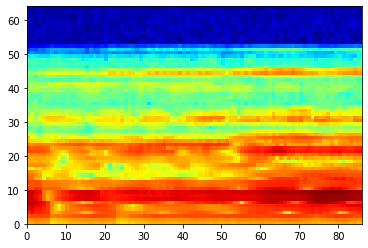

In [6]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
# print(len(DataSet_ALS))
X_generic, y_label = DataSet_ALS.__getitem__(16200)

plt.pcolor(X_generic, cmap='jet')
print('label = ', y_label)
fold_0_train,fold_0_val,fold_0_test = DataSet_ALS.get_kth_fold_inds(0)
# print(fold_0_train)
# print(fold_0_val)
# print(fold_0_test)

### NN-model

In [22]:
class ALS_FFNN(nn.Module):
    def __init__(self):
        super(ALS_FFNN,self).__init__() 
        # parameters
        file = open("config.json")
        config = json.load(file)            
        self.n_mel = config['data']['n_mel_channels']
        self.frames_in_segment = config['data']['supra_frame_length']
        self.drop1 = nn.Dropout(p=0.5)
        self.fc = nn.Linear(self.n_mel*self.frames_in_segment,1)
        nn.init.xavier_uniform_(self.fc.weight, gain=1.0,)
    
    def forward(self, x):
        out = x.view(-1,self.n_mel*self.frames_in_segment)
        out = self.drop1(out)
        out = self.fc(out)
        return out    

In [41]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):    
    MODEL_PATH = "model_backup/entire_model.pt"
    loss_train_history = np.ndarray((n_epochs))
    loss_val_history = np.ndarray((n_epochs))
    for epoch in range(1,n_epochs+1):
        loss_train = 0.0
        model.train()
        best_acc = 0
        for specs, labels in tqdm(train_loader, desc=f"Epoch {epoch}", leave=True): #train_loader:
            specs = specs.float()
            outputs = model(specs)
            outputs = outputs.squeeze()            
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        # prediction on val set        
        val_score = list()
        loss_val = 0.0
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            for spec, label in val_loader:
                spec = spec.float()                    
                pred = model(spec)
                pred = torch.squeeze(pred,1)                
                loss = loss_fn(pred, label)
                loss_val += loss.item()
                val_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)                        
                else:
                    pred = torch.tensor(0, dtype=torch.float64)
                if pred==label:
                    TP_TN_sum +=1
        acc_val = TP_TN_sum/len(val_score)    
        
        loss_train_history[epoch-1] = loss_train
        loss_val_history[epoch-1] = loss_val

        if acc_val>best_acc:
            torch.save(model, MODEL_PATH)

        if epoch==1 or epoch%2==0:                                                            
            print(f'{datetime.datetime.now()} Epoch {epoch}, Train loss {loss_train / len(train_loader):.3f}, Val loss {loss_val / len(val_loader):.3f}, Acc_val = {acc_val:.2f}')
    model = torch.load(MODEL_PATH)

    fig, ax = plt.subplots(figsize=(10,4))
    plt.rcParams.update({'font.size': 14})
    plt.plot(range(n_epochs), loss_train_history, label='Обучающий набор')
    plt.plot(range(n_epochs), loss_val_history, label='Проверочный набор')
    plt.legend()
    plt.xlabel('Эпоха')
    plt.ylabel('Ошибка обучения')
    plt.show()
    # Saving results
    # image_name = f'figures/loss_NN.jpg'
    # fig.savefig(image_name, format='jpg', dpi=110, bbox_inches='tight', pad_inches = 0.2)

### Single NN training & evaluation

2023-05-16 10:51:32.257961 Epoch 1, Train loss 34.347, Val loss 2.987, Acc_val = 0.63


2023-05-16 10:51:34.010378 Epoch 2, Train loss 28.216, Val loss 0.468, Acc_val = 0.92


2023-05-16 10:51:37.539434 Epoch 4, Train loss 21.095, Val loss 1.258, Acc_val = 0.88


2023-05-16 10:51:41.158165 Epoch 6, Train loss 17.555, Val loss 0.174, Acc_val = 0.97


2023-05-16 10:51:44.654821 Epoch 8, Train loss 14.781, Val loss 1.885, Acc_val = 0.87


2023-05-16 10:51:48.323796 Epoch 10, Train loss 13.449, Val loss 2.240, Acc_val = 0.88


2023-05-16 10:51:51.888036 Epoch 12, Train loss 10.972, Val loss 0.715, Acc_val = 0.91


2023-05-16 10:51:55.598764 Epoch 14, Train loss 10.094, Val loss 0.044, Acc_val = 0.98


2023-05-16 10:51:59.316159 Epoch 16, Train loss 8.723, Val loss 1.682, Acc_val = 0.87


2023-05-16 10:52:02.765205 Epoch 18, Train loss 7.697, Val loss 2.592, Acc_val = 0.84


2023-05-16 10:52:06.102076 Epoch 20, Train loss 6.879, Val loss 0.923, Acc_val = 0.89


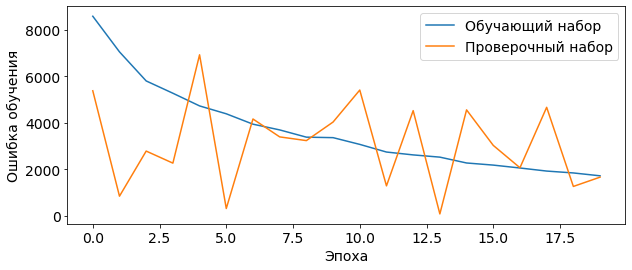

In [37]:
fold_0_train_inds,fold_0_val_inds,fold_0_test_inds = DataSet_ALS.get_kth_fold_inds(0)
train_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_train_inds)
val_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_val_inds)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True) # num_workers=1
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False) # num_workers=1

ALS_ffnn = ALS_FFNN()
ALS_ffnn.train()

# summary(ALS_cnn,(64*86))
# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(ALS_ffnn.parameters(),lr=1e-4)

# loss_fn = nn.CrossEntropyLoss()
# pos_weight = torch.ones([1])
# loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)

loss_fn = nn.BCEWithLogitsLoss()

training_loop(
    n_epochs=20,
    optimizer=optimizer,
    model=ALS_ffnn,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader = val_loader
)

In [ ]:
ALS_ffnn.eval()

test_set = torch.utils.data.dataset.Subset(DataSet_ALS, fold_0_test_inds)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False) # num_workers=1

test_score = list()
TP_TN_sum = 0
with torch.no_grad():
    for spec, label in test_loader:
        spec = spec.float()
        spec = spec.squeeze()
        pred = ALS_ffnn(spec)
        test_score.append(pred.numpy())
        if pred>0:
            pred = torch.tensor(1, dtype=torch.float64)
        else:
            pred = torch.tensor(0, dtype=torch.float64)
            # print('Neg example')    
        if pred==label:
            TP_TN_sum +=1

print('Acc = ', TP_TN_sum/len(test_score))

test_score = np.array(test_score).squeeze()
plt.plot(test_score)

### Train with 5-fold CV

In [19]:
def crossvalid(dataset=None, model = None, train = None, optimizer = None, n_epochs = 20, k_fold=5):    
    
    total_size = len(dataset)
    y_pred = np.ndarray(total_size)
    y_true = np.ndarray(total_size)

    for i in range(k_fold):
        
        inds_train,inds_val,inds_test = dataset.get_kth_fold_inds(i)                
        
        train_set = torch.utils.data.dataset.Subset(dataset,inds_train)
        val_set = torch.utils.data.dataset.Subset(dataset,inds_val)
        test_set = torch.utils.data.dataset.Subset(dataset,inds_test)
                
        train_loader = torch.utils.data.DataLoader(train_set, batch_size=50,shuffle=True)  # num_workers=2
        val_loader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False)
        test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)    # num_workers=2
        
        with torch.no_grad():
            for layer in model.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
        
        model.train()        

        loss_fn = nn.BCEWithLogitsLoss()

        train(
            n_epochs=n_epochs,
            optimizer=optimizer,
            model=model,
            loss_fn=loss_fn,
            train_loader=train_loader,
            val_loader=val_loader
        )

        # prediction on test set        
        test_score = list()
        TP_TN_sum = 0
        model.eval()
        with torch.no_grad():
            i = 0
            for spec, label in test_loader:
                spec = spec.float()
                spec = spec.squeeze()
                pred = model(spec)
                test_score.append(pred.numpy())
                if pred>0:
                    pred = torch.tensor(1, dtype=torch.float64)
                    y_pred[inds_test[i]] = 1
                else:
                    pred = torch.tensor(0, dtype=torch.float64)                
                    y_pred[inds_test[i]] = 0
                y_true[inds_test[i]] = label
                if pred==label:
                    TP_TN_sum +=1                
                i +=1                 
            print('Acc = ', TP_TN_sum/len(test_score))

    acc_sk = metrics.accuracy_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    prec = metrics.precision_score(y_true, y_pred)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    sensetivity = tp / (tp+fn)
    specificity = tn / (tn+fp)
    print('Final results')
    print(f'Acc_sk = {acc_sk:.2f}', )
    print(f'Prec = {prec:.2f}')
    print(f'Recall = {recall:.2f}')
    print(f'Sens = {sensetivity:.2f}')
    print(f'Spec = {specificity:.2f}')

        # val_acc = valid(res_model,criterion,optimizer,val_loader)
        # val_score.at[i] = val_acc
    
    return acc_sk
        
# https://stackoverflow.com/questions/60883696/k-fold-cross-validation-using-dataloaders-in-pytorch

#### Start script

Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 197.33it/s]


2023-05-16 11:17:21.941363 Epoch 1, Train loss 14.767, Val loss 1.923, Acc_val = 0.57


Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 196.47it/s]


2023-05-16 11:17:23.797091 Epoch 2, Train loss 12.615, Val loss 0.148, Acc_val = 0.94


Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 201.59it/s]


2023-05-16 11:17:27.379611 Epoch 4, Train loss 10.427, Val loss 0.345, Acc_val = 0.89


Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 199.94it/s]


2023-05-16 11:17:31.058756 Epoch 6, Train loss 9.156, Val loss 0.270, Acc_val = 0.91


Epoch 8: 100%|██████████| 250/250 [00:01<00:00, 193.38it/s]


2023-05-16 11:17:34.723038 Epoch 8, Train loss 7.991, Val loss 0.669, Acc_val = 0.87


Epoch 10: 100%|██████████| 250/250 [00:01<00:00, 193.52it/s]


2023-05-16 11:17:38.350274 Epoch 10, Train loss 7.048, Val loss 0.501, Acc_val = 0.89


Epoch 12: 100%|██████████| 250/250 [00:01<00:00, 195.73it/s]


2023-05-16 11:17:42.024832 Epoch 12, Train loss 6.607, Val loss 0.366, Acc_val = 0.90


Epoch 14: 100%|██████████| 250/250 [00:01<00:00, 200.27it/s]


2023-05-16 11:17:45.590799 Epoch 14, Train loss 6.101, Val loss 0.870, Acc_val = 0.87


Epoch 15: 100%|██████████| 250/250 [00:01<00:00, 184.59it/s]


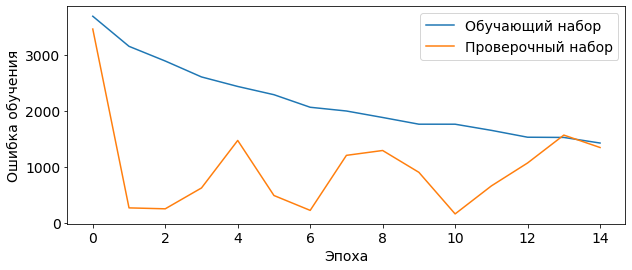

Acc =  0.8444940476190477


Epoch 1: 100%|██████████| 274/274 [00:01<00:00, 201.55it/s]


2023-05-16 11:17:50.164065 Epoch 1, Train loss 14.138, Val loss 0.661, Acc_val = 0.78


Epoch 2: 100%|██████████| 274/274 [00:01<00:00, 188.86it/s]


2023-05-16 11:17:51.966301 Epoch 2, Train loss 11.492, Val loss 0.078, Acc_val = 0.97


Epoch 4: 100%|██████████| 274/274 [00:01<00:00, 195.70it/s]


2023-05-16 11:17:55.447893 Epoch 4, Train loss 9.174, Val loss 0.582, Acc_val = 0.83


Epoch 6: 100%|██████████| 274/274 [00:01<00:00, 197.96it/s]


2023-05-16 11:17:58.930563 Epoch 6, Train loss 7.597, Val loss 0.545, Acc_val = 0.90


Epoch 8: 100%|██████████| 274/274 [00:01<00:00, 198.51it/s]


2023-05-16 11:18:02.309327 Epoch 8, Train loss 6.620, Val loss 0.776, Acc_val = 0.89


Epoch 10: 100%|██████████| 274/274 [00:01<00:00, 199.81it/s]


2023-05-16 11:18:05.825828 Epoch 10, Train loss 5.761, Val loss 2.051, Acc_val = 0.76


Epoch 12: 100%|██████████| 274/274 [00:01<00:00, 183.59it/s]


2023-05-16 11:18:09.399220 Epoch 12, Train loss 5.403, Val loss 0.875, Acc_val = 0.82


Epoch 14: 100%|██████████| 274/274 [00:01<00:00, 196.75it/s]


2023-05-16 11:18:12.867238 Epoch 14, Train loss 4.791, Val loss 1.254, Acc_val = 0.88


Epoch 15: 100%|██████████| 274/274 [00:01<00:00, 191.62it/s]


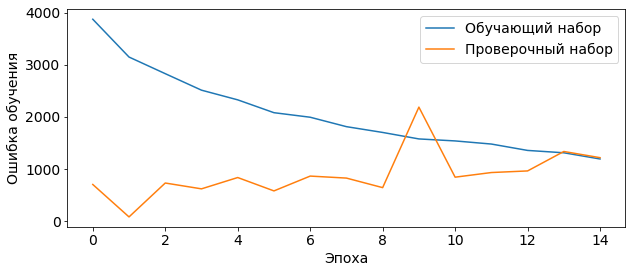

Acc =  0.7378668171557562


Epoch 1: 100%|██████████| 254/254 [00:01<00:00, 195.40it/s]


2023-05-16 11:18:17.229712 Epoch 1, Train loss 14.453, Val loss 4.518, Acc_val = 0.41


Epoch 2: 100%|██████████| 254/254 [00:01<00:00, 204.52it/s]


2023-05-16 11:18:18.877666 Epoch 2, Train loss 11.534, Val loss 1.803, Acc_val = 0.66


Epoch 4: 100%|██████████| 254/254 [00:01<00:00, 196.06it/s]


2023-05-16 11:18:22.314517 Epoch 4, Train loss 9.094, Val loss 1.998, Acc_val = 0.84


Epoch 6: 100%|██████████| 254/254 [00:01<00:00, 193.17it/s]


2023-05-16 11:18:25.744018 Epoch 6, Train loss 7.464, Val loss 2.804, Acc_val = 0.85


Epoch 8: 100%|██████████| 254/254 [00:01<00:00, 206.58it/s]


2023-05-16 11:18:29.058664 Epoch 8, Train loss 6.752, Val loss 1.842, Acc_val = 0.84


Epoch 10: 100%|██████████| 254/254 [00:01<00:00, 187.75it/s]


2023-05-16 11:18:32.503654 Epoch 10, Train loss 6.098, Val loss 2.071, Acc_val = 0.85


Epoch 12: 100%|██████████| 254/254 [00:01<00:00, 203.20it/s]


2023-05-16 11:18:35.811760 Epoch 12, Train loss 5.265, Val loss 1.712, Acc_val = 0.84


Epoch 14: 100%|██████████| 254/254 [00:01<00:00, 196.38it/s]


2023-05-16 11:18:39.230747 Epoch 14, Train loss 4.877, Val loss 1.818, Acc_val = 0.85


Epoch 15: 100%|██████████| 254/254 [00:01<00:00, 204.73it/s]


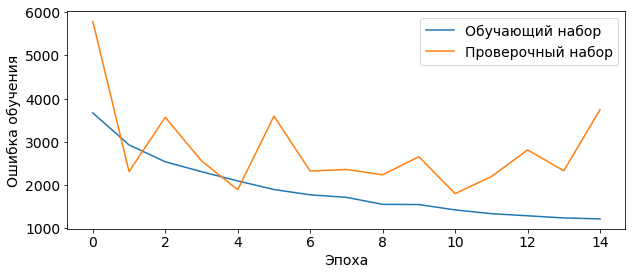

Acc =  0.5379834254143646


Epoch 1: 100%|██████████| 263/263 [00:01<00:00, 187.35it/s]


2023-05-16 11:18:43.631506 Epoch 1, Train loss 14.280, Val loss 4.830, Acc_val = 0.38


Epoch 2: 100%|██████████| 263/263 [00:01<00:00, 204.45it/s]


2023-05-16 11:18:45.241792 Epoch 2, Train loss 12.200, Val loss 0.552, Acc_val = 0.82


Epoch 4: 100%|██████████| 263/263 [00:01<00:00, 192.01it/s]


2023-05-16 11:18:48.589423 Epoch 4, Train loss 10.016, Val loss 2.861, Acc_val = 0.69


Epoch 6: 100%|██████████| 263/263 [00:01<00:00, 199.61it/s]


2023-05-16 11:18:51.852587 Epoch 6, Train loss 8.330, Val loss 3.650, Acc_val = 0.69


Epoch 8: 100%|██████████| 263/263 [00:01<00:00, 191.18it/s]


2023-05-16 11:18:55.250371 Epoch 8, Train loss 7.231, Val loss 10.120, Acc_val = 0.42


Epoch 10: 100%|██████████| 263/263 [00:01<00:00, 205.60it/s]


2023-05-16 11:18:58.478688 Epoch 10, Train loss 6.431, Val loss 8.800, Acc_val = 0.61


Epoch 12: 100%|██████████| 263/263 [00:01<00:00, 201.80it/s]


2023-05-16 11:19:01.847919 Epoch 12, Train loss 5.809, Val loss 8.392, Acc_val = 0.69


Epoch 14: 100%|██████████| 263/263 [00:01<00:00, 190.05it/s]


2023-05-16 11:19:05.122144 Epoch 14, Train loss 5.311, Val loss 8.593, Acc_val = 0.69


Epoch 15: 100%|██████████| 263/263 [00:01<00:00, 189.54it/s]


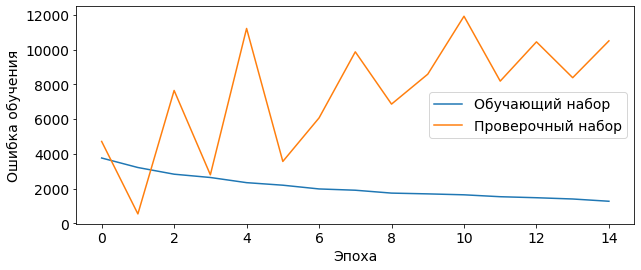

Acc =  0.8073741432285512


Epoch 1: 100%|██████████| 250/250 [00:01<00:00, 203.48it/s]


2023-05-16 11:19:09.640775 Epoch 1, Train loss 14.296, Val loss 1.515, Acc_val = 0.61


Epoch 2: 100%|██████████| 250/250 [00:01<00:00, 190.70it/s]


2023-05-16 11:19:11.701187 Epoch 2, Train loss 11.756, Val loss 2.028, Acc_val = 0.83


Epoch 4: 100%|██████████| 250/250 [00:01<00:00, 194.95it/s]


2023-05-16 11:19:15.345519 Epoch 4, Train loss 9.397, Val loss 2.520, Acc_val = 0.81


Epoch 6: 100%|██████████| 250/250 [00:01<00:00, 204.40it/s]


2023-05-16 11:19:19.018563 Epoch 6, Train loss 7.885, Val loss 2.725, Acc_val = 0.70


Epoch 8: 100%|██████████| 250/250 [00:01<00:00, 189.64it/s]


2023-05-16 11:19:22.681458 Epoch 8, Train loss 7.163, Val loss 3.439, Acc_val = 0.75


Epoch 10: 100%|██████████| 250/250 [00:01<00:00, 201.70it/s]


2023-05-16 11:19:26.321632 Epoch 10, Train loss 6.356, Val loss 4.378, Acc_val = 0.81


Epoch 12: 100%|██████████| 250/250 [00:01<00:00, 206.58it/s]


2023-05-16 11:19:29.943259 Epoch 12, Train loss 5.782, Val loss 5.382, Acc_val = 0.83


Epoch 14: 100%|██████████| 250/250 [00:01<00:00, 206.24it/s]


2023-05-16 11:19:33.613251 Epoch 14, Train loss 5.481, Val loss 4.302, Acc_val = 0.66


Epoch 15: 100%|██████████| 250/250 [00:01<00:00, 198.96it/s]


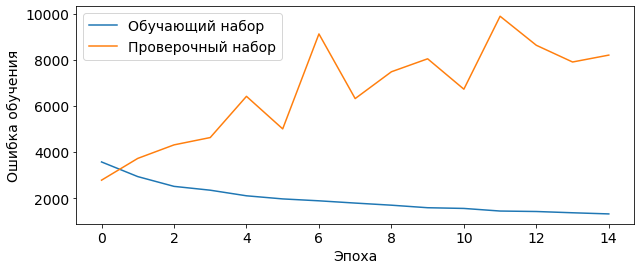

Acc =  0.7774993735905789
Final results
Acc_sk = 0.74
Prec = 0.72
Recall = 0.80
Sens = 0.80
Spec = 0.67


0.7365230214648534

In [42]:
dir_HC = '../wav'+ os.sep + 'HC' + os.sep
dir_ALS = '../wav' + os.sep + 'ALS' + os.sep

DataSet_ALS = ALSDataset(dir_HC, dir_ALS)
ALS_ffnn = ALS_FFNN()

# optimizer = optim.SGD(ALS_cnn.parameters(), lr=1e-3, momentum=0.10)
optimizer = optim.Adam(ALS_ffnn.parameters(),lr=2e-5, weight_decay=2e-1) # weight_decay is L2 regularization

crossvalid(dataset=DataSet_ALS, model = ALS_ffnn, train = training_loop, optimizer = optimizer, n_epochs=15, k_fold=5)

In [18]:
# Test 1
test_img = torch.rand(64,86)
test_img_row = test_img.view(-1,64*86)
print(test_img.shape)
print(test_img_row.shape)

# Test 2
test_img = torch.rand(1,10)
test_img_row = test_img.squeeze()
print(test_img.shape)
print(test_img_row.shape)

#Test 3
# print(torch.sigmoid(torch.tensor(-1)), torch.sigmoid(torch.tensor(0)), torch.sigmoid(torch.tensor(1)))


torch.Size([64, 86])
torch.Size([1, 5504])
torch.Size([1, 10])
torch.Size([10])


### CV-Fold selection

In [2]:
file_name =  'HC_ALS_table.xlsx' # path to file + file name

xls_file = pd.ExcelFile(file_name)
# print(xls_file.sheet_names)

# https://stackoverflow.com/questions/17071871/how-do-i-select-rows-from-a-dataframe-based-on-column-values

df_HC = xls_file.parse('Control')
df_ALS = xls_file.parse('ALS')
# print(df_HC['fold']==1)
for fold_num in range(1,6):
    HC_fold = df_HC.loc[df_HC['fold']==fold_num]
    ALS_fold = df_ALS.loc[df_ALS['fold']==fold_num]
    # print(HC_fold)
    # print(ALS_fold)
    print(np.hstack((HC_fold['Subject code'].to_numpy(), ALS_fold['Subject code'].to_numpy())))
    HC_age = (float)(HC_fold.loc[:, 'Age'].mean())
    HC_m = (HC_fold.loc[HC_fold['Sex']=='m'])
    HC_f = (HC_fold.loc[HC_fold['Sex']=='f'])
    ALS_age = (float)(ALS_fold.loc[:, 'Age'].mean())
    ALS_m = (ALS_fold.loc[ALS_fold['Sex']=='m'])
    ALS_f = (ALS_fold.loc[ALS_fold['Sex']=='f'])
    print(f'Fold {fold_num} HC age mean = {HC_age:.2f}, mens = {len(HC_m.index)}, womens = {len(HC_f.index)}')
    print(f'Fold {fold_num} ALS age mean = {ALS_age:.2f}, mens = {len(ALS_m.index)}, womens = {len(ALS_f.index)}')

[ 26  97 117  85  53  86 127  92 102  27  32  72  39]
Fold 1 HC age mean = 52.43, mens = 3, womens = 4
Fold 1 ALS age mean = 56.83, mens = 3, womens = 3
[ 28 123  63  99  81 125 129  68  21  55  48  78  42]
Fold 2 HC age mean = 53.71, mens = 3, womens = 4
Fold 2 ALS age mean = 58.33, mens = 4, womens = 2
[ 61  16 115 109 111   2 107  46  84  64  52  24  76]
Fold 3 HC age mean = 55.43, mens = 2, womens = 5
Fold 3 ALS age mean = 59.67, mens = 4, womens = 2
[ 77   6  65  24 131 119  25  94  62  28   8  98  22]
Fold 4 HC age mean = 53.00, mens = 3, womens = 3
Fold 4 ALS age mean = 60.86, mens = 5, womens = 2
[ 49  89   4  42 113 121  96  20  58  80  31 100]
Fold 5 HC age mean = 54.17, mens = 2, womens = 4
Fold 5 ALS age mean = 61.00, mens = 4, womens = 2
